In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow Version: {tf.__version__}")

2025-12-02 06:11:12.576664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764655872.987397      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764655873.148809      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow Version: 2.18.0


In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 384
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-4
SEED = 42
MAX_AGE = 240.0

BASE_INPUT = '/kaggle/input' 
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("Config Loaded.")

Config Loaded.


In [5]:
IMG_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 1e-4
SEED = 42
MAX_AGE = 240.0

BASE_INPUT = '/kaggle/input' 

TRAIN_CSV_PATH = os.path.join(BASE_INPUT, 'boneage_traindata.csv')
TEST_CSV_PATH = os.path.join(BASE_INPUT, 'boneage_testdata.csv')

print("Configuration Set.")

Configuration Set.


In [ ]:
#Image Directory
train_img_dir = None
for dirpath, dirnames, filenames in os.walk(BASE_INPUT):
    if len(filenames) > 100 and ('train' in dirpath.lower() or 'training' in dirpath.lower()):
        train_img_dir = dirpath
        print(f"Found Images in: {train_img_dir}")
        break

#Locate CSV
train_csv_path = None
for dirpath, dirnames, filenames in os.walk(BASE_INPUT):
    for f in filenames:
        if 'train' in f.lower() and f.endswith('.csv'):
            train_csv_path = os.path.join(dirpath, f)
            print(f"Found CSV at: {train_csv_path}")
            break
    if train_csv_path: break

if not train_img_dir or not train_csv_path:
    raise ValueError("Could not find dataset files! Check Kaggle input.")

#Load and Process Metadata
df = pd.read_csv(train_csv_path)

#Handling Gender Column
if 'Sex' in df.columns:
    df['gender'] = df['Sex'].map({'M': 1, 'F': 0})
else:
    df['gender'] = df['male'].astype(int)

# Map Image Paths and Filter Missing
df['path'] = df['id'].map(lambda x: os.path.join(train_img_dir, f"{x}.png"))
df['exists'] = df['path'].map(os.path.exists)
df = df[df['exists']].copy()

print(f"Loaded {len(df)} valid samples.")


In [8]:
#Normalizing Target (Age)
df['boneage_norm'] = df['boneage'] / MAX_AGE

#Creating Balanced Classes (Quantiles) for Classification
df['age_class'] = pd.qcut(df['boneage'], q=3, labels=[0, 1, 2]).astype(int)

#Split
df['stratify_col'] = df['gender'].astype(str) + "_" + df['age_class'].astype(str)

train_df, val_df = train_test_split(
    df, test_size=0.15, random_state=SEED, stratify=df['stratify_col']
)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")

Train: 10719 | Val: 1892


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

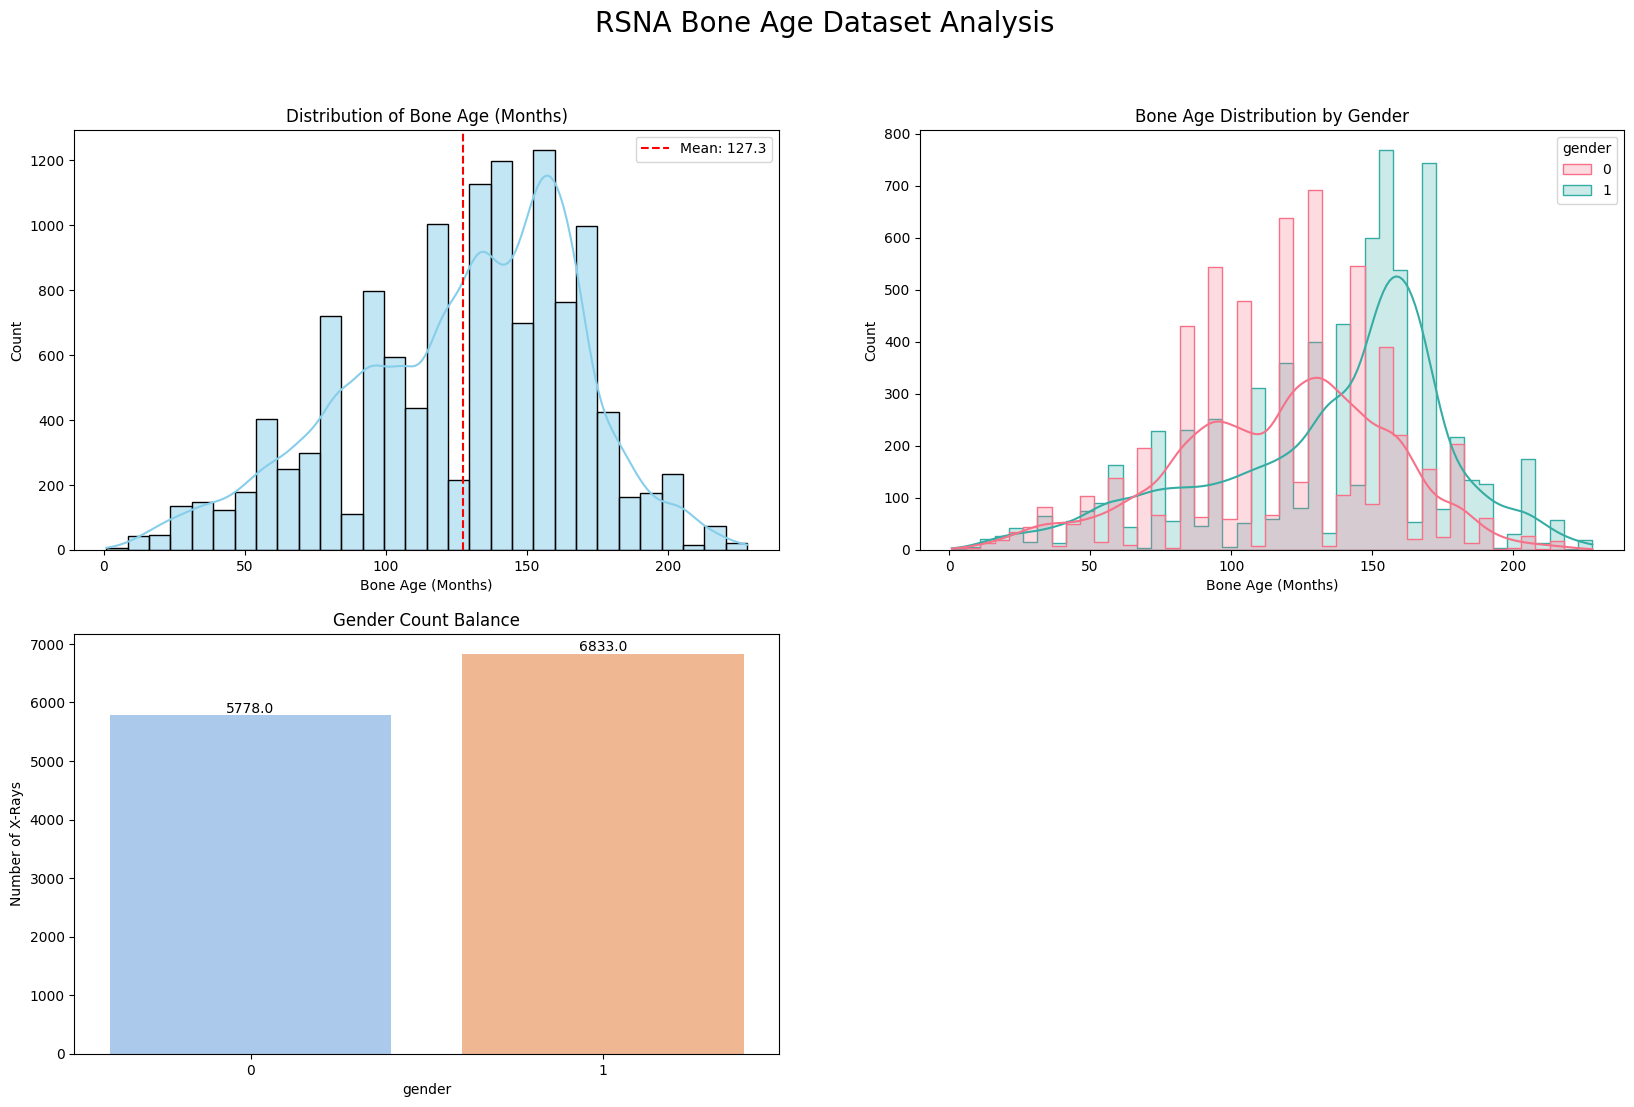

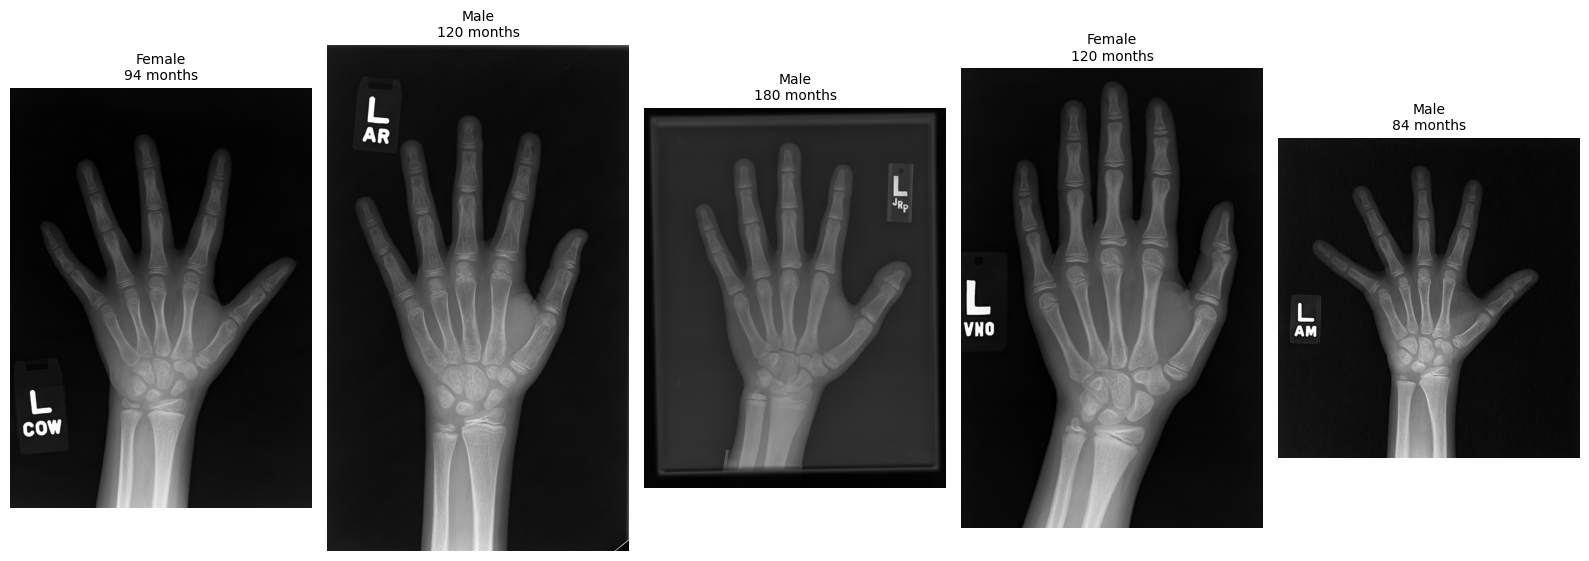


--- DATASET STATISTICS ---
Total Images: 12611
Age Range: 1 - 228 months
Mean Age: 127.32 months

Gender Distribution:
gender
1    54.182856
0    45.817144
Name: proportion, dtype: float64


In [35]:
#EDA CONFIGURATION
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
plt.suptitle('RSNA Bone Age Dataset Analysis', fontsize=20)

#Age Distribution(Target Variable)
sns.histplot(data=df, x='boneage', kde=True, bins=30, ax=ax[0, 0], color='skyblue')
ax[0, 0].set_title('Distribution of Bone Age (Months)')
ax[0, 0].set_xlabel('Bone Age (Months)')
ax[0, 0].axvline(df['boneage'].mean(), color='red', linestyle='--', label=f"Mean: {df['boneage'].mean():.1f}")
ax[0, 0].legend()

#Age Distribution by Gender(Bias Check)
gender_labels = {1: 'Male', 0: 'Female'} if df['gender'].dtype != 'O' else None
sns.histplot(data=df, x='boneage', hue='gender', kde=True, element="step", ax=ax[0, 1], palette='husl')
ax[0, 1].set_title('Bone Age Distribution by Gender')
ax[0, 1].set_xlabel('Bone Age (Months)')

#Gender Balance Count
sns.countplot(data=df, x='gender', ax=ax[1, 0], palette='pastel')
ax[1, 0].set_title('Gender Count Balance')
ax[1, 0].set_ylabel('Number of X-Rays')
for p in ax[1, 0].patches:
    ax[1, 0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom')

#Sample X-Rays Visualization
ax[1, 1].axis('off')

#Creating a separate figure for image samples to ensure they are large enough
plt.figure(figsize=(16, 6))
sample_images = df.sample(5, random_state=SEED)

for i, (idx, row) in enumerate(sample_images.iterrows()):
    img_path = row['path']
    age = row['boneage']
    gender_str = 'Male' if row['gender'] == 1 or row['gender'] == 'M' else 'Female'
    
    plt.subplot(1, 5, i + 1)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap='gray')
    else:
        plt.text(0.5, 0.5, "Image Not Found", ha='center')
        
    plt.title(f"{gender_str}\n{age} months", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

#Summary
print("\nDATASET STATISTICS")
print(f"Total Images: {len(df)}")
print(f"Age Range: {df['boneage'].min()} - {df['boneage'].max()} months")
print(f"Mean Age: {df['boneage'].mean():.2f} months")
print("\nGender Distribution:")
print(df['gender'].value_counts(normalize=True) * 100)

In [17]:
class BoneAgeGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, img_size=384, is_train=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.is_train = is_train
        self.indices = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.df))
        batch_indices = self.indices[start:end]
        
        X_img, X_gender, y_reg, y_cls = [], [], [], []

        for i in batch_indices:
            row = self.df.iloc[i]
            img = cv2.imread(row['path'])
            
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (self.img_size, self.img_size))
                
                if self.is_train: # Simple Augmentation
                    if np.random.rand() > 0.5: img = cv2.flip(img, 1)
                    if np.random.rand() > 0.5: 
                        img = cv2.convertScaleAbs(img, alpha=np.random.uniform(0.8, 1.2), beta=np.random.uniform(-10, 10))

                # Normalize for Xception [-1, 1]
                img = img.astype(np.float32) / 127.5 - 1.0
                
                X_img.append(img)
                X_gender.append(row['gender'])
                y_reg.append(row['boneage_norm'])
                y_cls.append(row['age_class'])

        # Return DICTIONARY inputs to match model layer names
        return (
            {'img_input': np.array(X_img), 'gender_input': np.array(X_gender)},
            {'reg_out': np.array(y_reg), 'cls_out': tf.keras.utils.to_categorical(y_cls, num_classes=3)}
        )

    def on_epoch_end(self):
        if self.is_train: np.random.shuffle(self.indices)

print("Generator Ready.")

Generator Ready.


In [18]:
train_gen = BoneAgeGenerator(train_df, BATCH_SIZE, IMG_SIZE, is_train=True)
val_gen = BoneAgeGenerator(val_df, BATCH_SIZE, IMG_SIZE, is_train=False)

In [19]:
def mae_months(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.abs((y_true * MAX_AGE) - (y_pred * MAX_AGE)))

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    #Image Branch
    img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='img_input')
    base = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=img_input)
    base.trainable = True 
    
    x = GlobalAveragePooling2D()(base.output)
    
    x = Dropout(0.5)(x) 
    
    #Gender Branch
    gender_input = Input(shape=(1,), name='gender_input')
    g = Dense(32, activation='relu')(gender_input)
    
    #Fusion
    concat = Concatenate()([x, g])
    z = Dense(256, activation='relu')(concat)
    z = BatchNormalization()(z)
    
    #Outputs
    reg_out = Dense(1, activation='linear', name='reg_out')(z)
    cls_out = Dense(3, activation='softmax', name='cls_out')(z)
    
    model = Model(inputs=[img_input, gender_input], outputs=[reg_out, cls_out])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
        loss={'reg_out': 'mae', 'cls_out': 'categorical_crossentropy'},
        loss_weights={'reg_out': 5.0, 'cls_out': 1.0},
        metrics={'reg_out': mae_months, 'cls_out': 'accuracy'}
    )

model.summary()
print("High-Dropout Model Compiled.")


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
✅ Using 2 GPUs
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ img_input[0][0]   │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 512, 512,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 512, 512,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 513, 513,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 256, 256,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 256, 256,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 256, 256,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 256, 256,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 256, 256,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 256, 256,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 256, 256,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 256, 256,  │        960 │ block1a_se_excit

 Total params: 11,187,315 (42.68 MB)

 Trainable params: 11,099,500 (42.34 MB)

 Non-trainable params: 87,815 (343.03 KB)

🚀 High-Dropout Model Compiled.


In [20]:
train_gen = BoneAgeGenerator(train_df, BATCH_SIZE, IMG_SIZE, is_train=True)
val_gen = BoneAgeGenerator(val_df, BATCH_SIZE, IMG_SIZE, is_train=False)

X, y = train_gen[0]

print(f"Batch Shape - Images: {X['img_input'].shape}")
print(f"Batch Shape - Genders: {X['gender_input'].shape}")
print(f"Target Shape - Regression: {y['reg_out'].shape}, Class: {y['cls_out'].shape}")

Batch Shape - Images: (16, 512, 512, 3)
Batch Shape - Genders: (16,)
Target Shape - Regression: (16,), Class: (16, 3)


In [21]:
def create_dual_model():
    #Image Branch
    img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='img_input') 
    
    base_model = Xception(weights='imagenet', include_top=False, input_tensor=img_input)
    base_model.trainable = True 
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    
    #Gender Branch
    gender_input = Input(shape=(1,), name='gender_input') 
    g = Dense(32, activation='relu')(gender_input)
    
    #Concatenate
    concat = Concatenate()([x, g])
    
    #Shared Dense Layers
    z = Dense(1024, activation='relu')(concat)
    z = BatchNormalization()(z)
    z = Dropout(0.4)(z)
    z = Dense(512, activation='relu')(z)
    
    #Outputs
    reg_out = Dense(1, activation='linear', name='reg_out')(z)
    cls_out = Dense(3, activation='softmax', name='cls_out')(z)
    
    model = Model(inputs=[img_input, gender_input], outputs=[reg_out, cls_out])
    return model

model = create_dual_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 255, 255,  │        864 │ img_input[0][0]   │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 255, 255,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 255, 255,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 253, 253,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 253, 253,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 253, 253,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 253, 253,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 253, 253,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 253, 253,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 253, 253,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 253, 253,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 127, 127,  │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 127, 127,  │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 127, 127,  │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 127, 127,  │          0 │ add_24[0][0]    

 Total params: 24,573,036 (93.74 MB)

 Trainable params: 24,516,460 (93.52 MB)

 Non-trainable params: 56,576 (221.00 KB)

In [22]:
def mae_months(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    #Calculate MAE
    return tf.reduce_mean(tf.abs((y_true * MAX_AGE) - (y_pred * MAX_AGE)))

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss={
        'reg_out': 'mae', 
        'cls_out': 'categorical_crossentropy'
    },
    loss_weights={'reg_out': 5.0, 'cls_out': 1.0}, 
    metrics={
        'reg_out': mae_months, 
        'cls_out': 'accuracy'
    }
)

print("Model Re-Compiled with corrected metric.")

Model Re-Compiled with corrected metric.


In [23]:
callbacks = [
    #Saves the model with the lowest Validation MAE
    ModelCheckpoint(
        'bone_age_best.keras', 
        monitor='val_reg_out_mae_months', 
        save_best_only=True, 
        mode='min', 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        verbose=1, 
        min_lr=1e-6
    ),
    EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
]

In [24]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/15
324/670 ━━━━━━━━━━━━━━━━━━━━ 7:04 1s/step - cls_out_accuracy: 0.4096 - cls_out_loss: 1.1512 - loss: 2.7784 - reg_out_loss: 0.3254 - reg_out_mae_months: 81.1295

E0000 00:00:1764656663.934958     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764656664.171696     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 06:24:32.919985: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[128,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,128,253,253]{3,2,1,0}, f32[15,128,253,253]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a

670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cls_out_accuracy: 0.4799 - cls_out_loss: 1.0344 - loss: 2.3841 - reg_out_loss: 0.2699 - reg_out_mae_months: 71.3343
Epoch 1: val_reg_out_mae_months improved from inf to 45.17051, saving model to bone_age_best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 1022s 1s/step - cls_out_accuracy: 0.4800 - cls_out_loss: 1.0341 - loss: 2.3832 - reg_out_loss: 0.2698 - reg_out_mae_months: 71.3163 - val_cls_out_accuracy: 0.7812 - val_cls_out_loss: 0.5833 - val_loss: 1.3461 - val_reg_out_loss: 0.1525 - val_reg_out_mae_months: 45.1705 - learning_rate: 1.0000e-04
Epoch 2/15
670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cls_out_accuracy: 0.7840 - cls_out_loss: 0.5312 - loss: 1.0685 - reg_out_loss: 0.1075 - reg_out_mae_months: 47.9036
Epoch 2: val_reg_out_mae_months did not improve from 45.17051
670/670 ━━━━━━━━━━━━━━━━━━━━ 896s 1s/step - cls_out_accuracy: 0.7840 - cls_out_loss: 0.5312 - loss: 1.0684 - reg_out_loss: 0.1074 - reg_out_mae_months: 47.9028 - val_cls_out_accuracy: 0

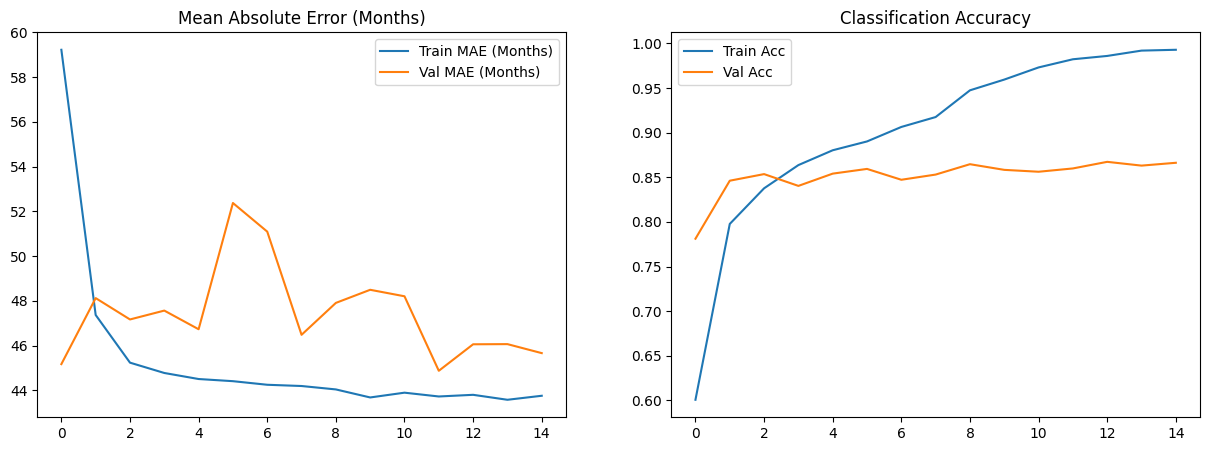

In [25]:
#Plotting Regression MAE (Months)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['reg_out_mae_months'], label='Train MAE (Months)')
plt.plot(history.history['val_reg_out_mae_months'], label='Val MAE (Months)')
plt.title('Mean Absolute Error (Months)')
plt.legend()

#Plotting Classification Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['cls_out_accuracy'], label='Train Acc')
plt.plot(history.history['val_cls_out_accuracy'], label='Val Acc')
plt.title('Classification Accuracy')
plt.legend()

plt.show()

In [31]:
#Loading the best weights
model.load_weights('bone_age_best.keras')

X_val_img = []
X_val_gender = []
y_val_reg = []
y_val_cls = []

print("Generating predictions...")

for i in range(len(val_gen)):
    # Retrieve the batch: inputs (dict) and targets (dict)
    batch_x, batch_y = val_gen[i]
    
    # Extract data using the KEYS we defined in the generator
    X_val_img.append(batch_x['img_input'])
    X_val_gender.append(batch_x['gender_input'])
    
    # Extract targets using keys
    y_val_reg.extend(batch_y['reg_out'])
    y_val_cls.extend(np.argmax(batch_y['cls_out'], axis=1))

X_val_img = np.concatenate(X_val_img)
X_val_gender = np.concatenate(X_val_gender)
y_val_reg = np.array(y_val_reg)
y_val_cls = np.array(y_val_cls)

preds = model.predict(
    {'img_input': X_val_img, 'gender_input': X_val_gender}, 
    batch_size=BATCH_SIZE, 
    verbose=1
)

pred_reg = preds[0].flatten()
pred_cls = np.argmax(preds[1], axis=1)

#Regression Metrics
true_months = y_val_reg * MAX_AGE
pred_months = pred_reg * MAX_AGE

mae = mean_absolute_error(true_months, pred_months)
r2 = r2_score(true_months, pred_months)

print(f"\n FINAL RESULTS:")
print(f"Regression MAE: {mae:.2f} months")
print(f"Regression R2:  {r2:.4f}")

#Classification Metrics
from sklearn.metrics import accuracy_score, classification_report
acc = accuracy_score(y_val_cls, pred_cls)
print(f"Classification Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_val_cls, pred_cls, target_names=['Low', 'Medium', 'High']))

Generating predictions...
119/119 ━━━━━━━━━━━━━━━━━━━━ 47s 365ms/step

🏆 FINAL RESULTS:
Regression MAE: 9.95 months
Regression R2:  0.9053
Classification Accuracy: 85.99%

Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.91      0.90       633
      Medium       0.79      0.80      0.80       644
        High       0.89      0.87      0.88       615

    accuracy                           0.86      1892
   macro avg       0.86      0.86      0.86      1892
weighted avg       0.86      0.86      0.86      1892




     FULL PERFORMANCE REPORT

Regression:
• MAE:  9.9518 months
• RMSE: 12.8658 months
• R²:   0.9053

Classification:
• Accuracy: 0.8599
• QWK:      0.8922

• Classification Report (Precision/Recall/F1):
              precision    recall  f1-score   support

         Low       0.90      0.91      0.90       633
      Medium       0.79      0.80      0.80       644
        High       0.89      0.87      0.88       615

    accuracy                           0.86      1892
   macro avg       0.86      0.86      0.86      1892
weighted avg       0.86      0.86      0.86      1892



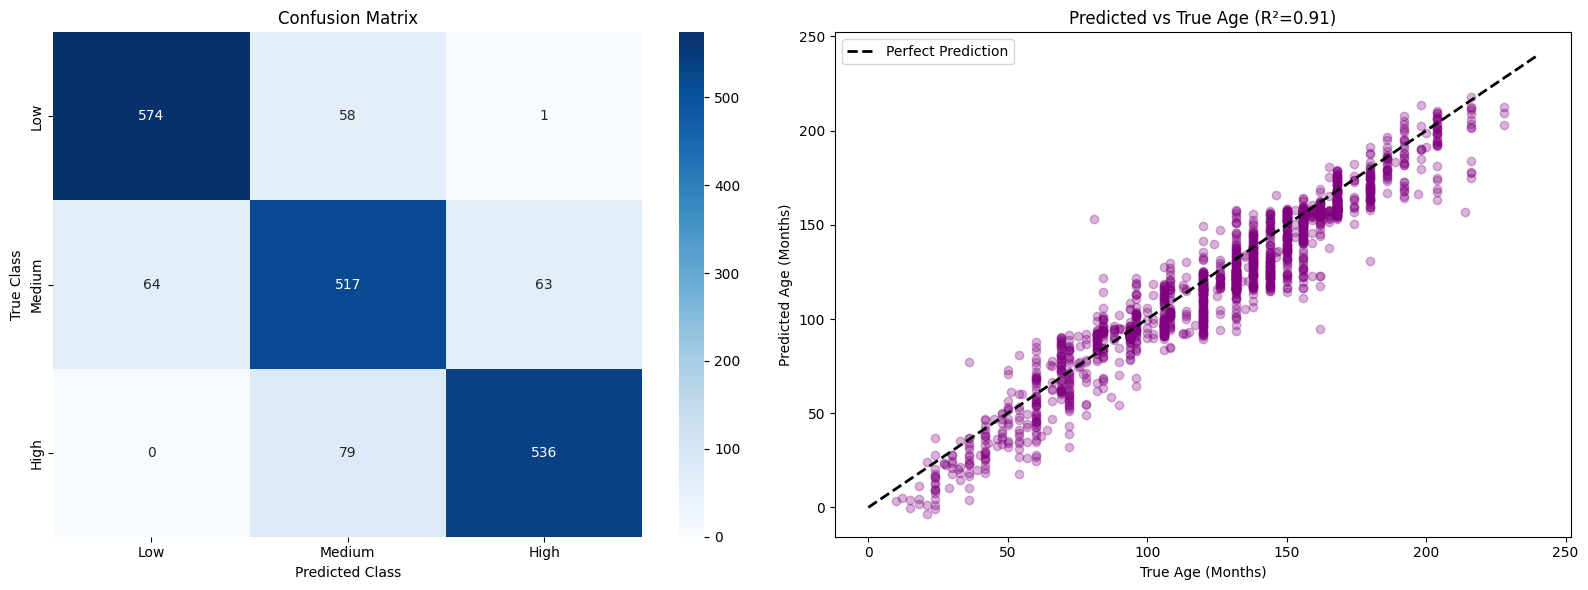

In [39]:
from sklearn.metrics import mean_squared_error, cohen_kappa_score, confusion_matrix, classification_report

print("     FULL PERFORMANCE REPORT\n")

#Regression Metrics
mae = mean_absolute_error(true_months, pred_months)

rmse = np.sqrt(mean_squared_error(true_months, pred_months))

r2 = r2_score(true_months, pred_months)

print(f"\nRegression:")
print(f"• MAE:  {mae:.4f} months")
print(f"• RMSE: {rmse:.4f} months")
print(f"• R²:   {r2:.4f}")

#Classification Metrics
acc = accuracy_score(y_val_cls, pred_cls)
qwk = cohen_kappa_score(y_val_cls, pred_cls, weights='quadratic')

print(f"\nClassification:")
print(f"• Accuracy: {acc:.4f}")
print(f"• QWK:      {qwk:.4f}")
print("\n• Classification Report (Precision/Recall/F1):")
print(classification_report(y_val_cls, pred_cls, target_names=['Low', 'Medium', 'High']))

#Visualization
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

cm = confusion_matrix(y_val_cls, pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
            xticklabels=['Low', 'Medium', 'High'], 
            yticklabels=['Low', 'Medium', 'High'])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted Class')
ax[0].set_ylabel('True Class')

ax[1].scatter(true_months, pred_months, alpha=0.3, color='purple')
ax[1].plot([0, 240], [0, 240], 'k--', lw=2, label='Perfect Prediction')
ax[1].set_title(f'Predicted vs True Age (R²={r2:.2f})')
ax[1].set_xlabel('True Age (Months)')
ax[1].set_ylabel('Predicted Age (Months)')
ax[1].legend()

plt.tight_layout()
plt.show()

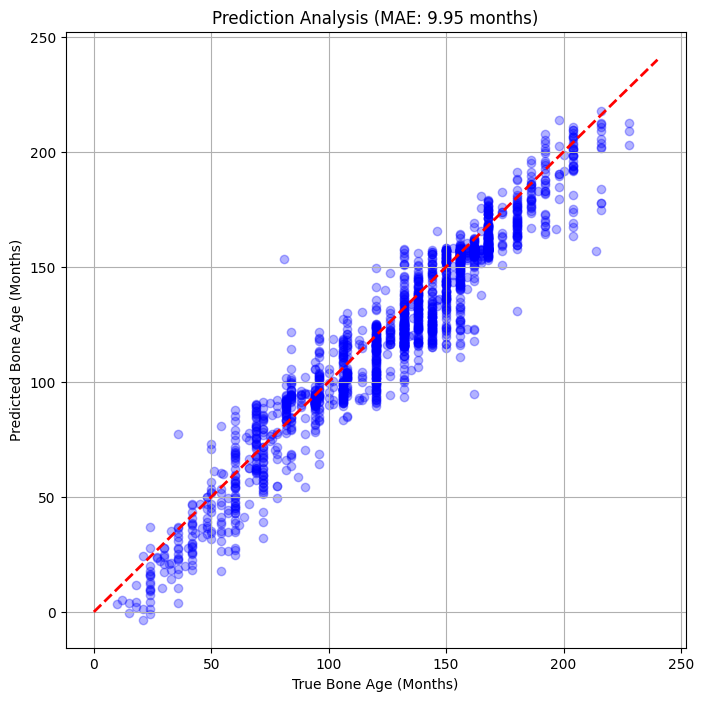

In [32]:
plt.figure(figsize=(8, 8))
plt.scatter(true_months, pred_months, alpha=0.3, color='blue')
plt.plot([0, 240], [0, 240], 'r--', linewidth=2)
plt.xlabel("True Bone Age (Months)")
plt.ylabel("Predicted Bone Age (Months)")
plt.title(f"Prediction Analysis (MAE: {mae:.2f} months)")
plt.grid(True)
plt.show()

♂️ Male MAE:   9.02 months
♀️ Female MAE: 11.05 months
⚠️ Gap:        2.03 months


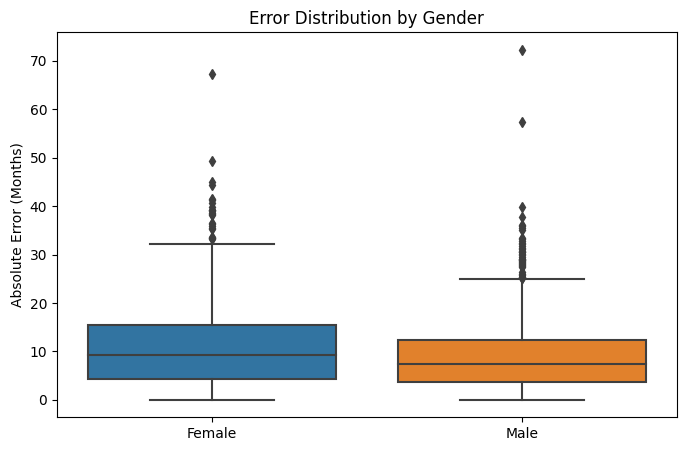

In [34]:
import numpy as np
from sklearn.metrics import mean_absolute_error

male_mask = (X_val_gender.flatten() == 1)
female_mask = (X_val_gender.flatten() == 0)

true_male = true_months[male_mask]
pred_male = pred_months[male_mask]

true_female = true_months[female_mask]
pred_female = pred_months[female_mask]

mae_male = mean_absolute_error(true_male, pred_male)
mae_female = mean_absolute_error(true_female, pred_female)

print(f"Male MAE:   {mae_male:.2f} months")
print(f"Female MAE: {mae_female:.2f} months")
print(f"Gap:        {abs(mae_male - mae_female):.2f} months")

plt.figure(figsize=(8, 5))
sns.boxplot(x=X_val_gender.flatten(), y=np.abs(true_months - pred_months))
plt.xticks([0, 1], ['Female', 'Male'])
plt.ylabel("Absolute Error (Months)")
plt.title("Error Distribution by Gender")
plt.show()

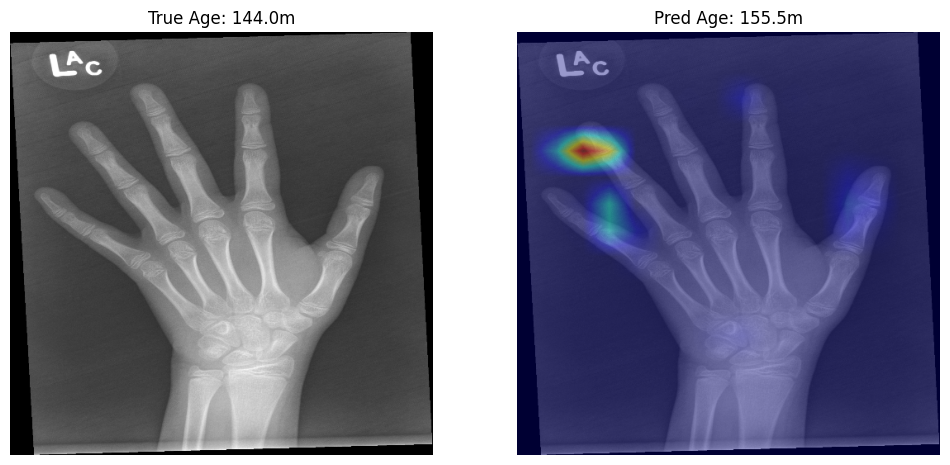

In [37]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act"):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs, 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output[0]]
    )

    with tf.GradientTape() as tape:
        img_array = tf.cast(img_array, tf.float32)
        dummy_gender = tf.zeros((1, 1))
        
        conv_outputs, predictions = grad_model([img_array, dummy_gender])
        
        score = predictions[0]

    grads = tape.gradient(score, conv_outputs)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

#Visualization
import cv2

idx = np.random.randint(0, len(X_val_img))
test_img = X_val_img[idx:idx+1] 

heatmap = make_gradcam_heatmap(test_img, model, last_conv_layer_name="block14_sepconv2_act")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
display_img = (test_img[0] + 1.0) / 2.0
plt.imshow(display_img)
plt.title(f"True Age: {true_months[idx]:.1f}m")
plt.axis('off')

plt.subplot(1, 2, 2)
heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap_colored = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

superimposed_img = cv2.addWeighted(np.uint8(255*display_img), 0.6, heatmap_colored, 0.4, 0)
plt.imshow(superimposed_img)
plt.title(f"Pred Age: {pred_months[idx]:.1f}m")
plt.axis('off')

plt.show()